In [1]:
import datetime
from datetime import date
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import os
import sys
import xarray as xr
import pandas as pd
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt

Data paths

In [162]:
nino_path = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/nino/nino34.long.anom.data.csv'
nino_final_path = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/nino/nino34.long.anom.data.final.csv'

NA_stations_path = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/station_coordinates/noramsnow_1979_2021_stations.csv'

SWE_path = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/nc_file/'
SWE_file_name = 'SWE_gapfilled_for_basin_06746095.nc'

SWE_test_file = SWE_path + SWE_file_name
print(SWE_test_file)

basin_coord_path = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/basin_coordinates/basin_cood.csv'

outputdata ='/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/data'

/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/nc_file/SWE_gapfilled_for_basin_06746095.nc


Nino index

In [4]:
nino_index = pd.read_csv(nino_path)

print(nino_index)



     1870    -1  -1.2  -0.83  -0.81  -1.27  -1.08  -1.04  -0.88  -0.53  -0.92  \
0    1871 -0.25 -0.58  -0.43  -0.50  -0.70  -0.53  -0.60  -0.33  -0.24  -0.33   
1    1872 -0.72 -0.62  -0.50  -0.77  -0.62  -0.52  -0.32  -0.85  -1.02  -0.94   
2    1873 -0.78 -1.01  -1.31  -0.67  -0.53  -0.48  -0.58  -0.39  -0.34  -0.78   
3    1874 -0.93 -1.06  -1.40  -0.94  -0.86  -0.72  -1.00  -1.05  -1.13  -1.25   
4    1875 -0.71 -0.37  -0.59  -0.87  -1.09  -0.76  -0.85  -0.81  -0.91  -0.83   
..    ...   ...   ...    ...    ...    ...    ...    ...    ...    ...    ...   
148  2019  0.51  0.62   0.81   0.67   0.61   0.66   0.41   0.19   0.11   0.55   
149  2020  0.64  0.48   0.36   0.49  -0.12  -0.21  -0.04  -0.42  -0.66  -1.19   
150  2021 -1.04 -0.94  -0.72  -0.55  -0.41  -0.06  -0.20  -0.38  -0.50  -0.78   
151  2022 -0.77 -0.68  -0.84  -0.90  -1.02  -0.77  -0.56  -0.96  -1.06  -0.99   
152  2023 -0.78 -0.62  -0.13   0.24   0.47   0.95   1.20   1.56   1.65   1.59   

     -0.79  -0.79.1  
0    

In [7]:
nino_index = pd.read_csv(nino_path)
nino_index.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
                      'Sep', 'Oct', 'Nov', 'Dec']

# Fill missing values with mean of the respective column 
nino_index_filled = nino_index.fillna(nino_index.mean())

# Verify missing values filled
print(nino_index_filled.head(10))

   Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0  1871 -0.25 -0.58 -0.43 -0.50 -0.70 -0.53 -0.60 -0.33 -0.24 -0.33 -0.31   
1  1872 -0.72 -0.62 -0.50 -0.77 -0.62 -0.52 -0.32 -0.85 -1.02 -0.94 -0.79   
2  1873 -0.78 -1.01 -1.31 -0.67 -0.53 -0.48 -0.58 -0.39 -0.34 -0.78 -0.77   
3  1874 -0.93 -1.06 -1.40 -0.94 -0.86 -0.72 -1.00 -1.05 -1.13 -1.25 -1.33   
4  1875 -0.71 -0.37 -0.59 -0.87 -1.09 -0.76 -0.85 -0.81 -0.91 -0.83 -0.64   
5  1876 -0.95 -1.20 -1.13 -1.18 -1.08 -0.43 -0.34 -0.16 -0.02  0.11  0.15   
6  1877  0.35  0.46  0.52  0.50  0.76  0.98  1.42  1.54  1.75  1.95  2.08   
7  1878  2.41  2.43  1.31  0.92  0.82  0.92  0.25 -0.11 -0.32 -0.53 -0.70   
8  1879 -0.55 -0.18 -0.24 -0.37 -0.83 -0.67 -0.77 -0.69 -0.83 -0.93 -1.14   
9  1880 -1.00 -0.73 -0.62 -0.57 -0.71 -0.61 -0.53 -0.24 -0.03  0.17  0.24   

    Dec  
0 -0.58  
1 -0.88  
2 -0.70  
3 -1.14  
4 -0.75  
5  0.23  
6  2.49  
7 -0.75  
8 -1.02  
9  0.18  


In [8]:
# Create DataFrame
nino_df = pd.DataFrame(nino_index)

# Reshape DataFrame using melt function
nino_df = nino_df.melt(id_vars=['Year'], var_name='Month', value_name='nino_value')

# Combine Year and Month columns into a single date column
nino_df['Date'] = pd.to_datetime(nino_df['Year'].astype(str) + '-' + nino_df['Month'], format='%Y-%b')

# Sort DataFrame by Date
nino_df = nino_df.sort_values('Date')

# Optionally drop Year and Month columns if not needed
nino_df = nino_df.drop(['Year', 'Month'], axis=1)

# Rearrange the columns
nino_df = nino_df[['Date', 'nino_value']]
# Write the DataFrame to a csv file
nino_df.to_csv(nino_final_path, index=False)

print(nino_df)

           Date  nino_value
0    1871-01-01       -0.25
153  1871-02-01       -0.58
306  1871-03-01       -0.43
459  1871-04-01       -0.50
612  1871-05-01       -0.70
...         ...         ...
1223 2023-08-01        1.56
1376 2023-09-01        1.65
1529 2023-10-01        1.59
1682 2023-11-01        2.01
1835 2023-12-01        1.81

[1836 rows x 2 columns]


In [145]:
basin_cood_df = pd.read_csv(basin_coord_path)

geometry_basin = [Point(lon, lat) for lon, lat in zip(basin_cood_df['lon'], basin_cood_df['lat'])]

# Create a GeoDataFrame from the DataFrame and the geometry column
gdf_basin = gpd.GeoDataFrame(basin_cood_df, geometry=geometry_basin, crs="EPSG:4326").reset_index()


display(gdf_basin,10)

,index,Basin,Name,lon,lat,geometry
0,0,02DD013,LA VASE RIVER AT NORTH BAY,-79.3951,46.26344,POINT (-79.39510 46.26344)
1,1,02EC002,BLACK RIVER NEAR WASHAGO,-79.2816,44.71367,POINT (-79.28160 44.71367)
2,2,05AA008,CROWSNEST RIVER AT FRANK,-114.4110,49.59732,POINT (-114.41100 49.59732)
3,3,05AD003,WATERTON RIVER NEAR WATERTON PARK,-113.8390,49.11366,POINT (-113.83900 49.11366)
4,4,05BB001,BOW RIVER AT BANFF,-115.5720,51.17223,POINT (-115.57200 51.17223)
...,...,...,...,...,...,...
63,63,13340600,NF CLEARWATER RIVER NR CANYON RANGER STATION ID,-115.6187,46.86400,POINT (-115.61870 46.86400)
64,64,14020000,UMATILLA RIVER ABOVE MEACHAM CREEK,-118.3887,45.39770,POINT (-118.38870 45.39770)
65,65,15290000,SUSITNA R NR PALMER AK,-149.3852,61.49010,POINT (-149.38520 61.49010)
66,66,15484000,SALCHA R NR SALCHAKET AK,-147.0973,64.26860,POINT (-147.09730 64.26860)


10

In [9]:
# Assuming you have a DataFrame named df with a 'Date' column

# Selecting data for a specific time period, for example, from January 2020 to June 2020
start_date = '1979-10-01'
end_date = '2022-07-01'

selected_data = nino_df[(nino_df['Date'] >= start_date) & (nino_df['Date'] <= end_date)]
variables = ['Date','nino_value']

print(selected_data)

           Date  nino_value
1485 1979-10-01        0.32
1638 1979-11-01        0.35
1791 1979-12-01        0.69
109  1980-01-01        0.55
262  1980-02-01        0.33
...         ...         ...
457  2022-03-01       -0.84
610  2022-04-01       -0.90
763  2022-05-01       -1.02
916  2022-06-01       -0.77
1069 2022-07-01       -0.56

[514 rows x 2 columns]


<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

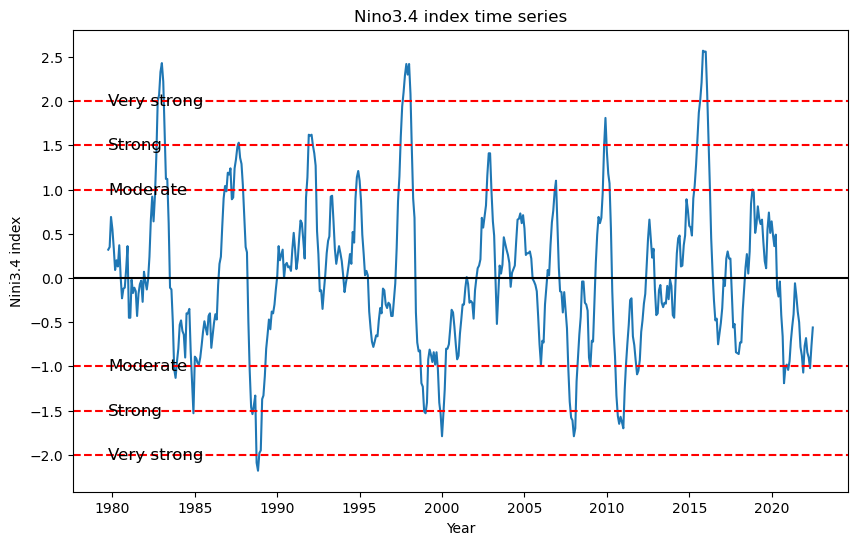

In [10]:
date = selected_data['Date']
Nino_value = selected_data['nino_value']

plt.figure(figsize=(10,6))
plt.plot(date,Nino_value, linestyle = '-')
plt.title('Nino3.4 index time series')
plt.xlabel('Year')
plt.ylabel('Nini3.4 index')
plt.axhline(0, color='black', linestyle='-')
plt.axhline(1, color='red', linestyle='--',label ='Moderate')
plt.axhline(1.5, color='red', linestyle='--', label = 'Strong')
plt.axhline(2, color='red', linestyle='--',label ='Very strong')
plt.axhline(-1, color='red', linestyle='--',label ='Moderate')
plt.axhline(-1.5, color='red', linestyle='--', label = 'Strong')
plt.axhline(-2, color='red', linestyle='--',label ='Very strong')
plt.text(date.iloc[0], 1.0, 'Moderate', color='black', fontsize=12, va='center')
plt.text(date.iloc[0], 1.5, 'Strong', color='black', fontsize=12, va='center')
plt.text(date.iloc[0], 2.0, 'Very strong', color='black', fontsize=12, va='center')
plt.text(date.iloc[0], -1.0, 'Moderate', color='black', fontsize=12, va='center')
plt.text(date.iloc[0], -1.5, 'Strong', color='black', fontsize=12, va='center')
plt.text(date.iloc[0], -2.0, 'Very strong', color='black', fontsize=12, va='center')
plt.yticks([-2.0,-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,2.5])
plt.savefig('Nino_index.png')
plt.show
plt.close


In [11]:
NA_stations = pd.read_csv(NA_stations_path)
# Create a geometry column with Point objects
geometry = [Point(lon, lat) for lon, lat in zip(NA_stations['lon'], NA_stations['lat'])]

# Create a GeoDataFrame from the DataFrame and the geometry column
gdf = gpd.GeoDataFrame(NA_stations, geometry=geometry, crs="EPSG:4326")

# Print the GeoDataFrame to see the structure
print(gdf)


       station_id        lat         lon                     geometry
0     ALE-05AA805  49.266666 -114.349998  POINT (-114.35000 49.26667)
1     ALE-05AA806  49.816666 -114.633331  POINT (-114.63333 49.81667)
2     ALE-05AD802  49.250000 -114.050003  POINT (-114.05000 49.25000)
3     ALE-05AE804  48.833332 -113.716667  POINT (-113.71667 48.83333)
4     ALE-05AE805  48.766666 -113.699997  POINT (-113.70000 48.76667)
...           ...        ...         ...                          ...
6607   US_NE_1599  45.223415  -68.575625   POINT (-68.57563 45.22342)
6608   US_NE_1600  45.476738  -68.553666   POINT (-68.55367 45.47674)
6609   US_NE_1598  45.323000  -68.580930   POINT (-68.58093 45.32300)
6610   US_NE_1602  43.872777  -70.457029   POINT (-70.45703 43.87278)
6611   US_NE_1604  44.097894  -70.597600   POINT (-70.59760 44.09789)

[6612 rows x 4 columns]


Plot stations available

/var/folders/g6/d7zppkyj7g98fd6kn97dkcq40000gn/T/ipykernel_59278/2890749961.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


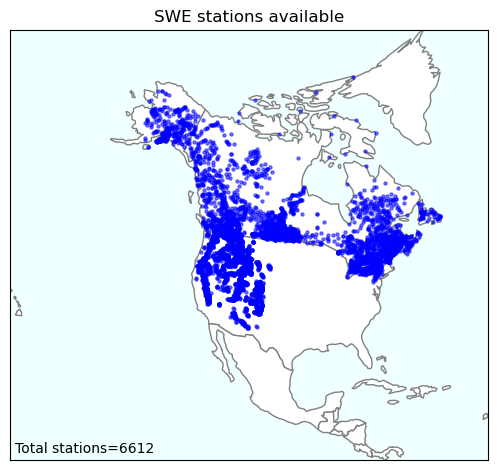

In [12]:
# Plot SWE stations available
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
NA_gdf = world_gdf[world_gdf['continent']=='North America'].to_crs("ESRI:102008")
ax = NA_gdf.plot(linewidth=1, edgecolor='grey', color='white')
SWE_stations_gdf = gdf.copy().to_crs("ESRI:102008")
SWE_stations_gdf.plot(ax=ax, color='b', alpha=.5, markersize=5)             
minx, miny, maxx, maxy = np.nanmin(NA_gdf.geometry.bounds.minx),np.nanmin(NA_gdf.geometry.bounds.miny),np.nanmax(NA_gdf.geometry.bounds.maxx),np.nanmax(NA_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('SWE stations available')
plt.text(.01, .01,'Total stations='+str(len(SWE_stations_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout();
plt.savefig('SWE_stations.png')
plt.show()
plt.close()

In [14]:
basins = pd.read_csv(NA_stations_path)
# Create a geometry column with Point objects
geometry = [Point(lon, lat) for lon, lat in zip(basins['lon'], basins['lat'])]

# Create a GeoDataFrame from the DataFrame and the geometry column
basin_gdf = gpd.GeoDataFrame(basins, geometry=geometry, crs="EPSG:4326")

# Print the GeoDataFrame to see the structure
print(basin_gdf)

       station_id        lat         lon                     geometry
0     ALE-05AA805  49.266666 -114.349998  POINT (-114.35000 49.26667)
1     ALE-05AA806  49.816666 -114.633331  POINT (-114.63333 49.81667)
2     ALE-05AD802  49.250000 -114.050003  POINT (-114.05000 49.25000)
3     ALE-05AE804  48.833332 -113.716667  POINT (-113.71667 48.83333)
4     ALE-05AE805  48.766666 -113.699997  POINT (-113.70000 48.76667)
...           ...        ...         ...                          ...
6607   US_NE_1599  45.223415  -68.575625   POINT (-68.57563 45.22342)
6608   US_NE_1600  45.476738  -68.553666   POINT (-68.55367 45.47674)
6609   US_NE_1598  45.323000  -68.580930   POINT (-68.58093 45.32300)
6610   US_NE_1602  43.872777  -70.457029   POINT (-70.45703 43.87278)
6611   US_NE_1604  44.097894  -70.597600   POINT (-70.59760 44.09789)

[6612 rows x 4 columns]


/var/folders/g6/d7zppkyj7g98fd6kn97dkcq40000gn/T/ipykernel_59278/2960278671.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_basin_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


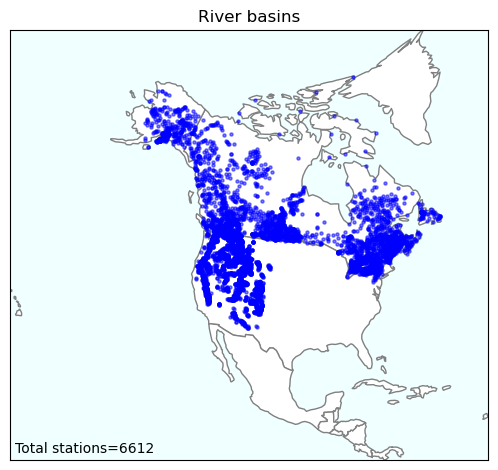

In [15]:
# Plot river basinds
world_basin_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
river_basin_gdf = world_gdf[world_gdf['continent']=='North America'].to_crs("ESRI:102008")
ax = river_basin_gdf.plot(linewidth=1, edgecolor='grey', color='white')
rbasin_gdf = basin_gdf.copy().to_crs("ESRI:102008")
rbasin_gdf.plot(ax=ax, color='b', alpha=.5, markersize=5)             
minx, miny, maxx, maxy = np.nanmin(river_basin_gdf.geometry.bounds.minx),np.nanmin(river_basin_gdf.geometry.bounds.miny),np.nanmax(river_basin_gdf.geometry.bounds.maxx),np.nanmax(river_basin_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('River basins')
plt.text(.01, .01,'Total stations='+str(len(rbasin_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)

# Annotate each point with the station name
#for x, y, name in zip(rbasin_gdf.geometry.x, rbasin_gdf.geometry.y, rbasin_gdf['Name']):
    #plt.annotate(name, xy=(x, y), xytext=(3, 3), textcoords="offset points")

#plt.text(.01, .01,'Total stations='+str(len(rbasin_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)

plt.tight_layout();
plt.savefig('river_basin.png')
plt.show()
plt.close()

In [16]:
basin_02DD013 = xr.open_dataset(SWE_path+"SWE_gapfilled_for_basin_02DD013.nc")

SWE_testbasin_ds = basin_02DD013.to_dataframe().drop(columns=['flag','donor_stations'])
# Flatten the DataFrame
SWE_testbasin_ds = SWE_testbasin_ds.reset_index()

# Drop rows with empty SWE
SWE_testbasin_ds = SWE_testbasin_ds.dropna(subset=['SWE'])

display(SWE_testbasin_ds, 10)




,time,station_id,SWE
3012,1987-12-30,ONR-6005,28.000000
3028,1988-01-15,ONR-6005,31.000000
3045,1988-02-01,ONR-6005,41.000000
3046,1988-02-02,ONR-6005,43.142857
3047,1988-02-03,ONR-6005,45.285713
...,...,...,...
15564,2022-05-12,ONR-6005,0.000000
15565,2022-05-13,ONR-6005,0.000000
15566,2022-05-14,ONR-6005,0.000000
15567,2022-05-15,ONR-6005,0.000000


10

In [17]:
basin_08LA001 = xr.open_dataset(SWE_path+"SWE_gapfilled_for_basin_08LA001.nc")

SWE_08LA001_ds = basin_08LA001.to_dataframe().drop(columns=['flag','donor_stations'])
# Flatten the DataFrame
SWE_08LA001_ds = SWE_08LA001_ds.reset_index()

# Drop rows with empty SWE
SWE_08LA001_ds = SWE_08LA001_ds.dropna(subset=['SWE'])

display(SWE_08LA001_ds, 10)

,time,station_id,SWE
0,1979-01-01,BCE-1C17,48.560001
6,1979-01-02,BCE-1C17,50.549999
12,1979-01-03,BCE-1C17,47.650002
30,1979-01-06,BCE-1C17,47.299999
120,1979-01-21,BCE-1C17,82.050003
...,...,...,...
95441,2022-07-20,BCE-1E10P,3.000000
95447,2022-07-21,BCE-1E10P,3.000000
95453,2022-07-22,BCE-1E10P,3.500000
95459,2022-07-23,BCE-1E10P,3.500000


10

In [79]:
# Initialize an empty DataFrame to store data
result_df = pd.DataFrame()
# Initialize an empty list to store dataframes
dfs = []
# Loop through each nc file in the directory
for filename in os.listdir(SWE_path):
    if filename.endswith(".nc"):
        # Open the dataset
        dataset = xr.open_dataset(os.path.join(SWE_path, filename))
        # Convert dataset to DataFrame
        basin_df = dataset.to_dataframe().drop(columns=['flag', 'donor_stations'])
        # Flatten the DataFrame
        basin_df = basin_df.reset_index()
        # Drop rows with empty SWE
        basin_df = basin_df.dropna(subset=['SWE'])
        # Add 'file_name' column with the filename
        basin_df['file_name'] = os.path.splitext(filename)[0]
        # Append DataFrame to the list
        dfs.append(basin_df)
# Concatenate the list of dataframes into the final dataframe
result_df = pd.concat(dfs)
# Display the resulting DataFrame
display(result_df.head(10))

,time,station_id,SWE,file_name
1,1979-01-01,BCE-4A20P,187.550003,SWE_gapfilled_for_basin_07FB001
3,1979-01-01,BCE-4A31,35.330002,SWE_gapfilled_for_basin_07FB001
5,1979-01-02,BCE-4A20P,187.580002,SWE_gapfilled_for_basin_07FB001
7,1979-01-02,BCE-4A31,34.369999,SWE_gapfilled_for_basin_07FB001
8,1979-01-03,BCE-4A20,71.349998,SWE_gapfilled_for_basin_07FB001
9,1979-01-03,BCE-4A20P,187.580002,SWE_gapfilled_for_basin_07FB001
11,1979-01-03,BCE-4A31,33.779999,SWE_gapfilled_for_basin_07FB001
12,1979-01-04,BCE-4A20,71.199997,SWE_gapfilled_for_basin_07FB001
13,1979-01-04,BCE-4A20P,187.600006,SWE_gapfilled_for_basin_07FB001
15,1979-01-04,BCE-4A31,33.470001,SWE_gapfilled_for_basin_07FB001


In [80]:
#for SWE_gapfilled_for_basin_02DD013.nc


# Convert time to datetime format
result_df['time'] = pd.to_datetime(result_df['time'], format="%Y-%m-%d")
# Create a new column that contains the year and month
result_df['month'] = result_df['time'].dt.to_period('M').dt.to_timestamp()
# Calculate average SWE for each time and station_id
SWE_avg = result_df.groupby(['month', 'station_id','file_name'])['SWE'].mean().reset_index()

display(SWE_avg, 10)

,month,station_id,file_name,SWE
0,1979-01-01,ALE-05AD803,SWE_gapfilled_for_basin_05AD003,132.274002
1,1979-01-01,ALE-05AD803-OLDP,SWE_gapfilled_for_basin_05AD003,70.706451
2,1979-01-01,ALE-05AD803P,SWE_gapfilled_for_basin_05AD003,71.324997
3,1979-01-01,ALE-05BA801,SWE_gapfilled_for_basin_05BB001,74.236359
4,1979-01-01,ALE-05BA802,SWE_gapfilled_for_basin_05BB001,66.205002
...,...,...,...,...
72032,2022-07-01,BCE-2G03P,SWE_gapfilled_for_basin_08NL070,0.000000
72033,2022-07-01,BCE-4A18P,SWE_gapfilled_for_basin_07EE007,26.519230
72034,2022-07-01,BCE-4A20P,SWE_gapfilled_for_basin_07FB001,0.136364
72035,2022-07-01,YT-10AD-M2,SWE_gapfilled_for_basin_10BE001,0.000000


10

In [81]:
SWE_avg_month = SWE_avg.groupby(['month','file_name'])['SWE'].mean().reset_index()

display(SWE_avg_month, 10)

,month,file_name,SWE
0,1979-01-01,SWE_gapfilled_for_basin_01013500,29.703001
1,1979-01-01,SWE_gapfilled_for_basin_05AD003,91.435150
2,1979-01-01,SWE_gapfilled_for_basin_05BB001,98.322655
3,1979-01-01,SWE_gapfilled_for_basin_05DA009,46.998333
4,1979-01-01,SWE_gapfilled_for_basin_06043500,158.795151
...,...,...,...
22502,2022-07-01,SWE_gapfilled_for_basin_08NL007,0.000000
22503,2022-07-01,SWE_gapfilled_for_basin_08NL038,0.000000
22504,2022-07-01,SWE_gapfilled_for_basin_08NL070,0.000000
22505,2022-07-01,SWE_gapfilled_for_basin_10BE001,0.000000


10

In [82]:
#for SWE_gapfilled_for_basin_02DD013.nc
# Firstly, we need to make sure that both 'YearMonth' and 'time' are in datetime format
selected_data['Date'] = pd.to_datetime(selected_data['Date'])
SWE_avg_month['month'] = pd.to_datetime(SWE_avg_month['month'])

# Merge the dataframes
df_merged = pd.merge(left=SWE_avg_month, right=selected_data, right_on='Date', left_on='month')

df_merged = df_merged.drop(['Date'], axis=1).rename(columns={'Value':'Nino'})

display(df_merged, 10)

/var/folders/g6/d7zppkyj7g98fd6kn97dkcq40000gn/T/ipykernel_59278/3837227602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Date'] = pd.to_datetime(selected_data['Date'])


,month,file_name,SWE,nino_value
0,1979-10-01,SWE_gapfilled_for_basin_05BB001,17.920584,0.32
1,1979-10-01,SWE_gapfilled_for_basin_06043500,30.940807,0.32
2,1979-10-01,SWE_gapfilled_for_basin_06632400,22.949167,0.32
3,1979-10-01,SWE_gapfilled_for_basin_06746095,2.048387,0.32
4,1979-10-01,SWE_gapfilled_for_basin_07AA002,3.995000,0.32
...,...,...,...,...
22256,2022-07-01,SWE_gapfilled_for_basin_08NL007,0.000000,-0.56
22257,2022-07-01,SWE_gapfilled_for_basin_08NL038,0.000000,-0.56
22258,2022-07-01,SWE_gapfilled_for_basin_08NL070,0.000000,-0.56
22259,2022-07-01,SWE_gapfilled_for_basin_10BE001,0.000000,-0.56


10

In [84]:
# Filter data for November through April
#filtered_df = df_merged[(df_merged['month'].dt.month >= 11) | (df_merged['month'].dt.month <= 4)]

# Create a mask to filter data for November through April
mask = (df_merged['month'].dt.month >= 11) | (df_merged['month'].dt.month <= 4)

# Filter the DataFrame using the mask
filtered_df = df_merged[mask]

# Drop rows for January through October
filtered_df = filtered_df[~((filtered_df['month'].dt.month >= 5) & (filtered_df['month'].dt.month <= 10))]

display(filtered_df,10)


,month,file_name,SWE,nino_value
32,1979-11-01,SWE_gapfilled_for_basin_05AD003,22.290417,0.35
33,1979-11-01,SWE_gapfilled_for_basin_05BB001,23.924099,0.35
34,1979-11-01,SWE_gapfilled_for_basin_06043500,88.973831,0.35
35,1979-11-01,SWE_gapfilled_for_basin_06632400,89.475998,0.35
36,1979-11-01,SWE_gapfilled_for_basin_06746095,90.339333,0.35
...,...,...,...,...
22191,2022-04-01,SWE_gapfilled_for_basin_13240000,185.419998,-0.90
22192,2022-04-01,SWE_gapfilled_for_basin_13337000,610.983826,-0.90
22193,2022-04-01,SWE_gapfilled_for_basin_13340000,525.219116,-0.90
22194,2022-04-01,SWE_gapfilled_for_basin_15290000,717.046631,-0.90


10

In [94]:
# Create a new column for water year starting from November
filtered_df['water_year'] = filtered_df['month'].apply(lambda x: x.year if x.month < 11 else x.year + 1)
#isplay(filtered_df.head(10))

# Group by water year
grouped_by_water_year = filtered_df.groupby(['water_year', 'file_name'])

# Calculate the mean for each water year
mean_swe_by_water_year = grouped_by_water_year['SWE'].mean()
mean_nino_by_water_year = grouped_by_water_year['nino_value'].mean()

# Create a DataFrame with both annual averages
annual_avg_df = pd.DataFrame({'SWE': mean_swe_by_water_year, 'Nino Index': mean_nino_by_water_year})
annual_avg_df = annual_avg_df.reset_index()
display(annual_avg_df)

,water_year,file_name,SWE,Nino Index
0,1980,SWE_gapfilled_for_basin_01013500,72.256042,0.292500
1,1980,SWE_gapfilled_for_basin_02EC002,52.298378,0.372000
2,1980,SWE_gapfilled_for_basin_05AA008,392.852997,0.206667
3,1980,SWE_gapfilled_for_basin_05AD003,209.586670,0.368333
4,1980,SWE_gapfilled_for_basin_05BB001,234.902328,0.368333
...,...,...,...,...
2826,2022,SWE_gapfilled_for_basin_13337000,483.988586,-0.852000
2827,2022,SWE_gapfilled_for_basin_13340000,387.107605,-0.852000
2828,2022,SWE_gapfilled_for_basin_15290000,528.591187,-0.797500
2829,2022,SWE_gapfilled_for_basin_15484000,330.200012,-0.840000


In [95]:
#for SWE_gapfilled_for_basin_02DD013.nc
#select El-nino events >1.00
select_Elnino = annual_avg_df[annual_avg_df['Nino Index']>1.00]

display(select_Elnino)

,water_year,file_name,SWE,Nino Index
194,1983,SWE_gapfilled_for_basin_01013500,107.796738,1.865000
195,1983,SWE_gapfilled_for_basin_02EC002,50.335499,2.167500
196,1983,SWE_gapfilled_for_basin_05AA008,298.916656,1.865000
197,1983,SWE_gapfilled_for_basin_05AD003,246.537964,1.976667
198,1983,SWE_gapfilled_for_basin_05BB001,209.699051,1.976667
...,...,...,...,...
2447,2016,SWE_gapfilled_for_basin_13340600,505.350983,2.075000
2448,2016,SWE_gapfilled_for_basin_14020000,397.893829,2.075000
2449,2016,SWE_gapfilled_for_basin_15290000,376.442719,2.075000
2450,2016,SWE_gapfilled_for_basin_15484000,99.059998,1.050000


#Composite analysis

In [97]:
# Assuming that 'file_name' is the column that contains the file names.
sorted_df_all = annual_avg_df
display(sorted_df_all.columns)
grouped_df = sorted_df_all.groupby('file_name')

# Compute mean SWE for each group (here, each file).
mean_df_all = grouped_df['SWE'].mean()

# Use transform to subtract the mean on a per-group basis
sorted_df_all.loc[:, 'SWE_anomaly'] = sorted_df_all.groupby('file_name')['SWE'].transform(lambda x: x - x.mean())

#display(sorted_df_all,10)
display(sorted_df_all,10)

Index(['water_year', 'file_name', 'SWE', 'Nino Index', 'SWE_anomaly'], dtype='object')

,water_year,file_name,SWE,Nino Index,SWE_anomaly
0,1980,SWE_gapfilled_for_basin_01013500,72.256042,0.292500,-56.391861
1,1980,SWE_gapfilled_for_basin_02EC002,52.298378,0.372000,-17.151550
2,1980,SWE_gapfilled_for_basin_05AA008,392.852997,0.206667,18.461823
3,1980,SWE_gapfilled_for_basin_05AD003,209.586670,0.368333,-77.143402
4,1980,SWE_gapfilled_for_basin_05BB001,234.902328,0.368333,-5.634781
...,...,...,...,...,...
2826,2022,SWE_gapfilled_for_basin_13337000,483.988586,-0.852000,100.057800
2827,2022,SWE_gapfilled_for_basin_13340000,387.107605,-0.852000,75.696594
2828,2022,SWE_gapfilled_for_basin_15290000,528.591187,-0.797500,227.509644
2829,2022,SWE_gapfilled_for_basin_15484000,330.200012,-0.840000,203.477173


10

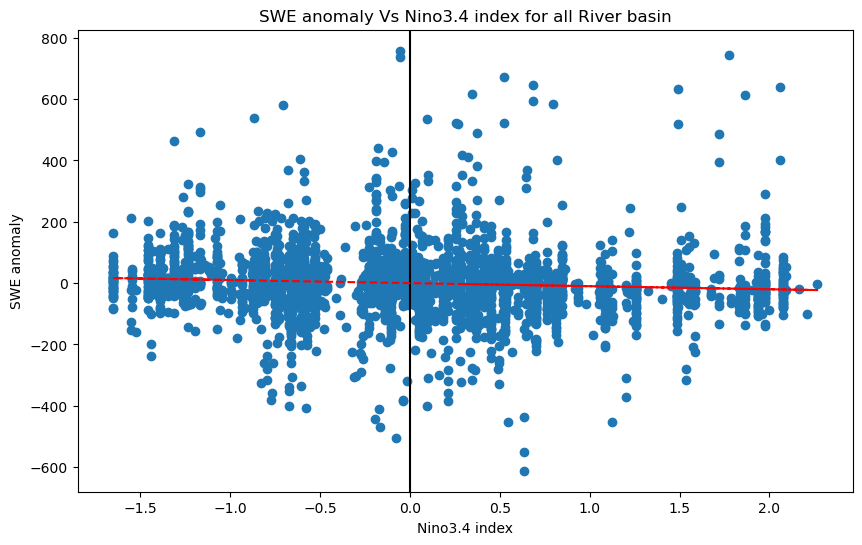

In [98]:

#scatter plot of SWE Vs Nino index
plt.figure(figsize=(10,6))
plt.scatter(sorted_df_all['Nino Index'],sorted_df_all['SWE_anomaly'])
plt.title('SWE anomaly Vs Nino3.4 index for all River basin')
plt.xlabel('Nino3.4 index')
plt.ylabel('SWE anomaly')
plt.axvline(0, color='black', linestyle='-')

#plot trend line
z = np.polyfit(sorted_df_all['Nino Index'],sorted_df_all['SWE_anomaly'], 1)
p = np.poly1d(z)
plt.plot(sorted_df_all['Nino Index'], p(sorted_df_all['Nino Index']), "r--")
plt.show
plt.savefig('SWE_anomaly_02DD013.png')

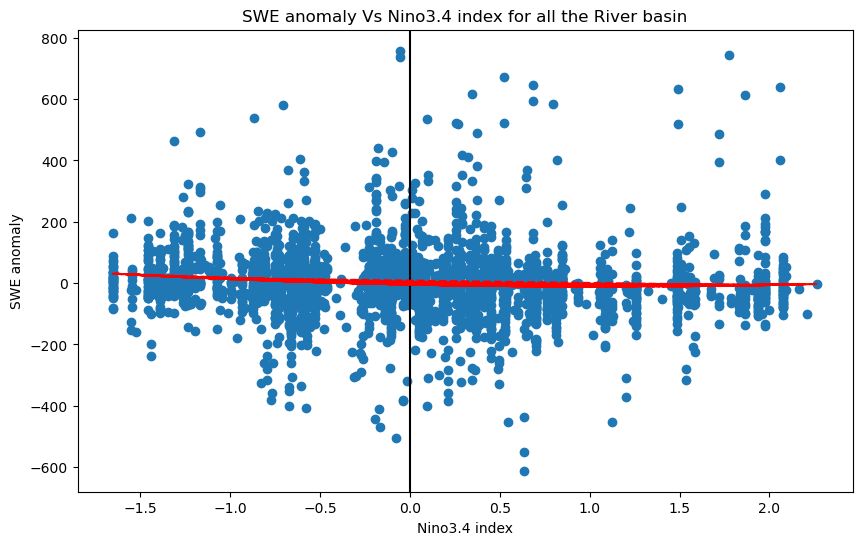

<Figure size 640x480 with 0 Axes>

In [99]:
plt.figure(figsize=(10, 6))
plt.scatter(sorted_df_all['Nino Index'], sorted_df_all['SWE_anomaly'])
plt.title('SWE anomaly Vs Nino3.4 index for all the River basin')
plt.xlabel('Nino3.4 index')
plt.ylabel('SWE anomaly')
plt.axvline(0, color='black', linestyle='-')

# plot quadratic trend line
z = np.polyfit(sorted_df_all['Nino Index'], sorted_df_all['SWE_anomaly'], 2)
p = np.poly1d(z)
plt.plot(sorted_df_all['Nino Index'], p(sorted_df_all['Nino Index']), "r--")

plt.show()
plt.savefig('SWE_anomaly_02DD013.png')


In [100]:
display(sorted_df_all.columns)

Index(['water_year', 'file_name', 'SWE', 'Nino Index', 'SWE_anomaly'], dtype='object')

In [120]:
# Assuming 'sorted_df_all' is your dataframe
file_names = sorted_df_all['file_name'].unique()
top_10_dict = {}
bottom_10_dict = {}

for file in file_names:
    sorted_df_all.loc[sorted_df_all['file_name'] == file, 'rank'] = sorted_df_all.loc[
        sorted_df_all['file_name'] == file, 'SWE_anomaly'].rank(ascending=False)

    # Sort dataframe by 'rank' and then use head and tail method to create new dataframes
    sorted_file_df = sorted_df_all.loc[sorted_df_all['file_name'] == file].sort_values(by='rank')

    top_10_dict[file] = sorted_file_df.head(10)
    bottom_10_dict[file] = sorted_file_df.tail(10)
    
# converting the dictionary to dataframes
top_10_df = pd.concat(top_10_dict)
bottom_10_df = pd.concat(bottom_10_dict)

# resetting the index
top_10_df.reset_index(inplace=True, drop=True)
bottom_10_df.reset_index(inplace=True, drop=True)

# print the dataframes
display(top_10_df,20)
display(bottom_10_df,20)


,water_year,file_name,SWE,Nino Index,SWE_anomaly,rank
0,2008,SWE_gapfilled_for_basin_01013500,229.762329,-1.387500,101.114426,1.0
1,1991,SWE_gapfilled_for_basin_01013500,222.524719,0.285000,93.876816,2.0
2,1984,SWE_gapfilled_for_basin_01013500,216.793854,-0.602500,88.145950,3.0
3,1997,SWE_gapfilled_for_basin_01013500,170.070129,-0.097500,41.422226,4.0
4,1982,SWE_gapfilled_for_basin_01013500,162.463882,0.012500,33.815979,5.0
...,...,...,...,...,...,...
675,2011,SWE_gapfilled_for_basin_08ME028,575.000000,-1.233333,108.081238,6.0
676,2018,SWE_gapfilled_for_basin_08ME028,537.500000,-0.670000,70.581238,7.0
677,2017,SWE_gapfilled_for_basin_08ME028,522.500000,-0.055000,55.581238,8.0
678,2012,SWE_gapfilled_for_basin_08ME028,519.000000,-0.577500,52.081238,9.0


20

,water_year,file_name,SWE,Nino Index,SWE_anomaly,rank
0,1990,SWE_gapfilled_for_basin_01013500,100.630219,0.210000,-28.017685,33.0
1,2004,SWE_gapfilled_for_basin_01013500,96.486267,0.097500,-32.161636,34.0
2,2002,SWE_gapfilled_for_basin_01013500,89.551285,0.027500,-39.096619,35.0
3,1989,SWE_gapfilled_for_basin_01013500,88.460266,-1.440000,-40.187637,36.0
4,1985,SWE_gapfilled_for_basin_01013500,85.124512,-0.935000,-43.523392,37.0
...,...,...,...,...,...,...
675,2014,SWE_gapfilled_for_basin_08ME028,291.750000,-0.165000,-175.168762,24.0
676,2001,SWE_gapfilled_for_basin_08ME028,290.500000,-0.727500,-176.418762,25.0
677,2005,SWE_gapfilled_for_basin_08ME028,289.333344,0.366667,-177.585419,26.0
678,2021,SWE_gapfilled_for_basin_08ME028,288.000000,-0.960000,-178.918762,27.0


20

In [127]:
top_10_avg_df = top_10_df.groupby('file_name').mean()[['Nino Index', 'SWE_anomaly']].reset_index()
bottom_10_avg_df = bottom_10_df.groupby('file_name').mean()[['Nino Index', 'SWE_anomaly']].reset_index()

# Split the `file_name` and create a new column `basin_name` using last index of the split
top_10_avg_df['basin_name'] = top_10_avg_df['file_name'].apply(lambda x: x.split('_')[-1])
bottom_10_avg_df['basin_name'] = bottom_10_avg_df['file_name'].apply(lambda x: x.split('_')[-1])

display(top_10_avg_df, 20)
display(bottom_10_avg_df, 20)


,file_name,Nino Index,SWE_anomaly,basin_name
0,SWE_gapfilled_for_basin_01013500,0.163600,49.611328,01013500
1,SWE_gapfilled_for_basin_02DD013,0.133783,29.237293,02DD013
2,SWE_gapfilled_for_basin_02EC002,-0.306900,26.078999,02EC002
3,SWE_gapfilled_for_basin_05AA008,-0.236250,109.036423,05AA008
4,SWE_gapfilled_for_basin_05AD003,-0.443500,126.628098,05AD003
...,...,...,...,...
63,SWE_gapfilled_for_basin_13340600,-0.818167,162.505859,13340600
64,SWE_gapfilled_for_basin_14020000,-0.351167,166.851349,14020000
65,SWE_gapfilled_for_basin_15290000,0.017083,152.324265,15290000
66,SWE_gapfilled_for_basin_15484000,-0.240167,94.765175,15484000


20

,file_name,Nino Index,SWE_anomaly,basin_name
0,SWE_gapfilled_for_basin_01013500,-0.271550,-48.128857,01013500
1,SWE_gapfilled_for_basin_02DD013,0.096950,-25.039606,02DD013
2,SWE_gapfilled_for_basin_02EC002,0.700550,-26.643164,02EC002
3,SWE_gapfilled_for_basin_05AA008,0.469583,-95.315521,05AA008
4,SWE_gapfilled_for_basin_05AD003,0.124500,-93.949539,05AD003
...,...,...,...,...
63,SWE_gapfilled_for_basin_13340600,0.561333,-146.475174,13340600
64,SWE_gapfilled_for_basin_14020000,0.306500,-158.157806,14020000
65,SWE_gapfilled_for_basin_15290000,0.043333,-122.313087,15290000
66,SWE_gapfilled_for_basin_15484000,0.133417,-72.007004,15484000


20

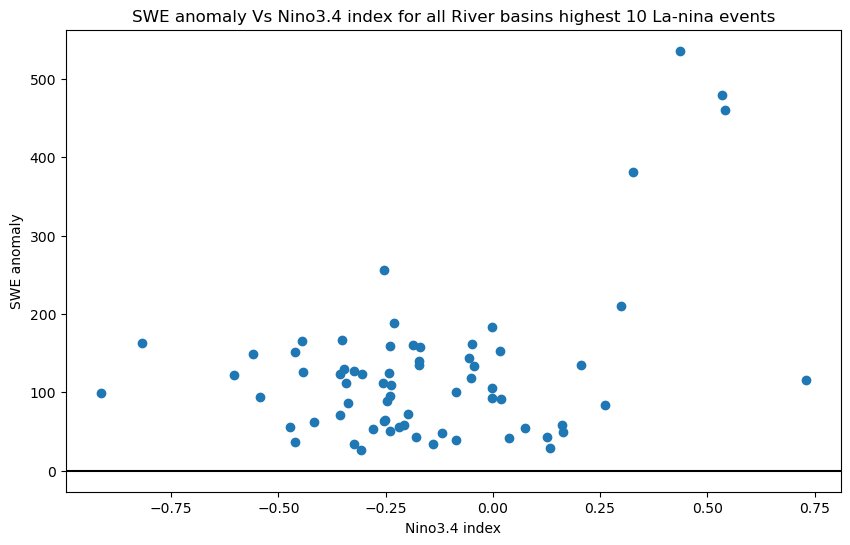

In [139]:

#scatter plot of SWE Vs Nino index for El-nino
plt.figure(figsize=(10,6))
plt.scatter(top_10_avg_df['Nino Index'],top_10_avg_df['SWE_anomaly'])
plt.title('SWE anomaly Vs Nino3.4 index for all River basins highest 10 La-nina events')
plt.xlabel('Nino3.4 index')
plt.ylabel('SWE anomaly')

plt.axhline(0, color='black', linestyle='-')

plt.show
plt.savefig('elnino_SWE_anomaly_02DD013.png')

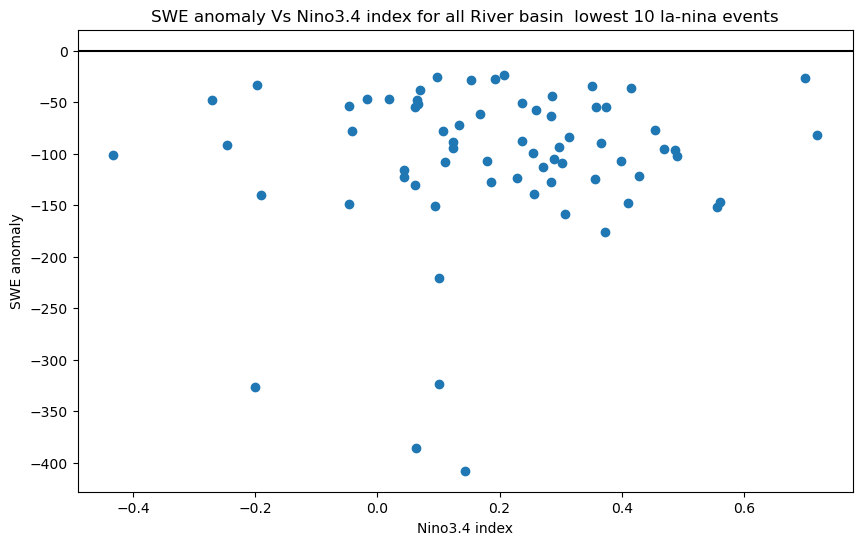

In [140]:

#scatter plot of SWE Vs Nino index for La-Nina
plt.figure(figsize=(10,6))
plt.scatter(bottom_10_avg_df['Nino Index'],bottom_10_avg_df['SWE_anomaly'])
plt.title('SWE anomaly Vs Nino3.4 index for all River basin  lowest 10 la-nina events')
plt.xlabel('Nino3.4 index')
plt.ylabel('SWE anomaly')
plt.axhline(0, color='black', linestyle='-')

plt.show
plt.savefig('lanina_SWE_anomaly_02DD013.png')

In [163]:
import os

joined_top_10_basin_df = pd.merge(top_10_avg_df, gdf_basin, left_on='basin_name', right_on='Basin')
joined_top_10_basin_df = joined_top_10_basin_df.drop(['Basin', 'Name', 'lon', 'lat', 'index'], axis=1)
joined_top_10_basin_df.to_csv(os.path.join(outputdata, "joined_top_10_basin_df.csv"), index=False)

joined_bottom_10_basin_df = pd.merge(bottom_10_avg_df, gdf_basin, left_on='basin_name', right_on='Basin')
joined_bottom_10_basin_df = joined_bottom_10_basin_df.drop(['Basin', 'Name', 'lon', 'lat', 'index'], axis=1)
joined_bottom_10_basin_df.to_csv(os.path.join(outputdata, "joined_bottom_10_basin_df.csv"), index=False)

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

/var/folders/g6/d7zppkyj7g98fd6kn97dkcq40000gn/T/ipykernel_59278/1048571787.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


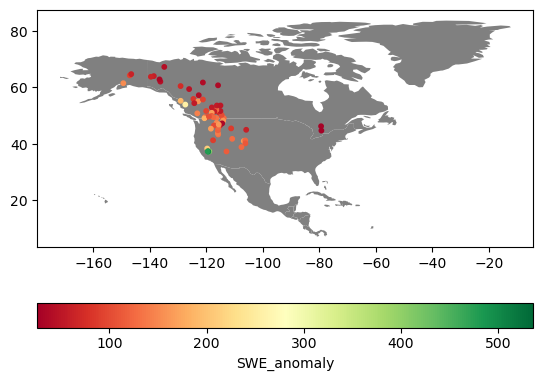

In [180]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt

url = 'http://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_land.geojson'
df = pd.read_csv(outputdata + '/joined_top_10_basin_df.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Load built-in Geopandas dataset
display(gpd.datasets.available)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select North America
na = world[world['continent'] == 'North America']

fig, ax = plt.subplots(1, 1)

# Plot North America as the background
na.plot(ax=ax, linewidth=0.8, color='gray')

# Then superimpose the points on top of the North America map
gdf.plot(column='SWE_anomaly', ax=ax, legend=True, markersize=10, cmap='RdYlGn',
         legend_kwds={'label': 'SWE_anomaly', 'orientation': 'horizontal'})

plt.show()